### French English.
In this notebook we are going to create an `Encoder-Decoder` model that will learn to translate text from one domain to the other. We are going to create a model that translates sentences from French to English. The dataset that we will be using can be found [here](http://www.manythings.org/anki/)

Note: This notebook is based on the previous notebook so there will be fewer changes. Where there's changes I will highlight the changes.

### Setup

In [1]:
!pip install tensorflow_text

     |████████████████████████████████| 4.3 MB 7.4 MB/s 


In [2]:
import numpy as np
import typing
from typing import Any, Tuple

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

tf.__version__

'2.5.0'

### Data.

We are going to use the data from  http://www.manythings.org/anki/ This data contains langauge pair translations in the format:

```
May I borrow this book? ¿Puedo tomar prestado este libro?
```

### Dataset Preparation
I've already downloaded the dataset and uploaded it on my google drive. For data preparation we are going to do the following:

1. Add a start and end token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

### Mounting my google drive.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
path_to_file = '/content/drive/My Drive/NLP Data/seq2seq/en-fr/fra.txt'
os.path.exists(path_to_file)

True

In [8]:
def load_data(path):
  lines = open(path, encoding='utf-8').read().split('\n')
  pairs = [line.split('\t') for line in lines]
  inp, targ = [], []
  for pair in pairs:
    if (len(pair) != 3):
      continue
    else:
      a, b, _ = pair
      inp.append(b.lower())
      targ.append(a.lower())
  return targ, inp

In [9]:
targ, inp = load_data(path_to_file)
print(len(inp), len(targ))
print(inp[0], targ[0])

190206 190206
va ! go.


### Creating the dataset.
From this list of strings we are going to create a `tf.data.Dataset` of strings that shuffles and batches them efficiently.


In [10]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 128

dataset = tf.data.Dataset.from_tensor_slices((inp, 
                                              targ)).shuffle(
                                                  BUFFER_SIZE).batch(
                                                      BATCH_SIZE)

In [11]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b"mais non ! tu n'es pas si vieille que \xc3\xa7a !"
 b"c'est l'endroit dont je t'ai parl\xc3\xa9."
 b'je veux que tom revienne.'
 b"ils ont port\xc3\xa9 l'eau dans des seaux."
 b"je suppose que je ferais mieux de m'en aller."], shape=(5,), dtype=string)

tf.Tensor(
[b"come on. you're not that old." b'this is the place i told you about.'
 b'i want tom to come back.' b'they carried water in buckets.'
 b"i guess i'd better be going."], shape=(5,), dtype=string)


### Text preprocessing.

In this notebook we are going to create a model that takes in string inputs and output string outputs not the model that takes strings and output logits.

### Standardization.
The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.

The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

The `tensroflow_text` package contains a unicode normalize operation:

In [13]:
example_text = tf.constant('¿Todavía está en casa?') # This is for spanish, but the preprocessing is the same

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


Unicode normalization will be the first step in the text standardization function:

In [14]:
def tf_lower_and_split_punct(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)
  text = tf.strings.join(['<sos>', text, '<eos>'], separator=' ')
  return text

In [15]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
<sos> ¿ todavia esta en casa ? <eos>


### Text Vectorization
This standardization function will be wrapped up in a `preprocessing.TextVectorization` layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

The `TextVectorization` layer and many other `experimental.preprocessing` layers have an adapt method. This method reads one epoch of the training data, and works a lot like `Model.fix`. This adapt method initializes the layer based on the data. 

In [22]:
max_vocab_size = 10_000

input_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size
    )
output_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size
    )
input_text_processor.adapt(inp)
output_text_processor.adapt(targ)

The `preprocessing.TextVectorization` has a method called `get_vocabulary()` which list the number of uninque words in each source.



In [23]:
print(input_text_processor.get_vocabulary()[:5])
print(output_text_processor.get_vocabulary()[:5])

['', '[UNK]', '<sos>', '<eos>', '.']
['', '[UNK]', '<sos>', '<eos>', '.']


In [24]:
print("Vocab size french: ", len(input_text_processor.get_vocabulary()))
print("Vocab size english: ", output_text_processor.vocabulary_size())

Vocab size french:  10000
Vocab size english:  10000


Now these layers can convert a batch of strings into a batch of token IDs:

In [25]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2,  126,  258,   34,   21,  361,    9,   49,  703,   10],
       [   2,   31, 2004,  314,    5,  320,  182,    4,    3,    0],
       [   2,    5,   47,   10,   15, 2681,    4,    3,    0,    0]])>

### Getting the vocabulary.
We can use the `get_vocabulary()` method to convert tokens IDS 
 back to text.

In [26]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'<sos> mais non ! tu nes pas si vieille que ca ! <eos>         '

In [27]:
example_tokens[1]

<tf.Tensor: shape=(22,), dtype=int64, numpy=
array([   2,   31, 2004,  314,    5,  320,  182,    4,    3,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])>

In [28]:
embedding_dim = 256
units = 1024

### The `Enconder.`

We are going to start by building the ecoder the blue part of the diagram. The encoder:

1. Takes a list of tokens IDs (from `input_text_processor`)
2. Looks up an embbeding vector for each token using the keras `Layers.Embedding`
3. Processed the embeddings into a new sequence a `GRU` and then returns:
* The processed sequence. This will be passed to the attention head.
* The internal state. This will be used to initialize the decoder

In [29]:
class Encoder(keras.layers.Layer):
  def __init__(self, input_vocab_size,
               embedding_dim,
               enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size
    self.embedding = keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)
    self.gru = keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    vectors = self.embedding(tokens)
    output, state = self.gru(vectors, initial_state=state)
    return output, state


### The attention head

The decoder uses attention to selectively focus on parts of the input sequence. The attention takes a sequence of vectors as input for each example and returns an "attention" vector for each example. This attention layer is similar to a `layers.GlobalAveragePoling1D` but the attention layer performs a weighted average.


In [30]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)
    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    w1_query = self.W1(query)
    w2_key = self.W2(value)
    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask
    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    return context_vector, attention_weights

### The Decoder.

The decoder's job is to generate predictions for the next output token.

1. The decoder receives the complete encoder output.
2. It uses an RNN to keep track of what it has generated so far.
3. It uses its RNN output as the query to the attention over the encoder's output, producing the context vector.
4. It combines the RNN output and the context vector using Equation 3 (below) to generate the "attention vector".
5. It generates logit predictions for the next token based on the "attention vector".

<img src="https://github.com/tensorflow/text/blob/master/docs/tutorials/images/attention_equation_3.jpg?raw=1" alt="attention equation 3" width="800">

Here is the `Decoder` class and its initializer. The initializer creates all the necessary layers.




In [35]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

In [43]:
class Decoder(keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    self.embedding = keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)
    self.gru = keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.attention = BahdanauAttention(self.dec_units)

    self.Wc = keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)
    self.fc = keras.layers.Dense(self.output_vocab_size)

  def call(self,
         inputs: DecoderInput,
         state=None)  -> Tuple[DecoderOutput, tf.Tensor]:
    vectors = self.embedding(inputs.new_tokens)
    rnn_output, state = self.gru(vectors, initial_state=state)
    context_vector, attention_weights = self.attention(
        query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
    context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)
    attention_vector = self.Wc(context_and_rnn_output)
    logits = self.fc(attention_vector)
    return DecoderOutput(logits, attention_weights), state

The **encoder** processes its full input sequence with a single call to its RNN. This implementation of the **decoder** _can_ do that as well for efficient training. But this notebook will run the decoder in a loop for a few reasons:

* Flexibility: Writing the loop gives you direct control over the training procedure.
* Clarity: It's possible to do masking tricks and use `layers.RNN`, or `tfa.seq2seq` APIs to pack this all into a single call. But writing it out as a loop may be clearer. 

### Training.
Now that we have all the model components, it's time to start training the model. We'll need:

- A loss function and optimizer to perform the optimization.
- A training step function defining how to update the model for each input/target batch.
- A training loop to drive the training and save checkpoints.

### Loss function


In [44]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    
  def __call__(self, y_true, y_pred):
    loss = self.loss(y_true, y_pred)
    mask = tf.cast(y_true != 0, tf.float32)
    loss *= mask
    return tf.reduce_sum(loss)

### The train step

Start with a model class, the training process will be implemented as the `train_step` method on this model.

Here the `train_step` method is a wrapper around the `_train_step` implementation which will come later. This wrapper includes a switch to turn on and off `tf.function` compilation, to make debugging easier.

The `_train_step` method, handles the remaining steps except for actually running the decoder.

The `_loop_step` method executes the decoder and calculates the incremental loss and new decoder state (`dec_state`).

In [45]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function

  def train_step(self, inputs):
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)
  
  def _preprocess(self, input_text, target_text):
    # Convert the text to token IDs
    input_tokens = self.input_text_processor(input_text)
    target_tokens = self.output_text_processor(target_text)
    # Convert IDs to masks.
    input_mask = input_tokens != 0
    target_mask = target_tokens != 0
    return input_tokens, input_mask, target_tokens, target_mask

  def _train_step(self, inputs):
    input_text, target_text = inputs  

    (input_tokens, input_mask,
    target_tokens, target_mask) = self._preprocess(input_text, target_text)
    max_target_length = tf.shape(target_tokens)[1]
    with tf.GradientTape() as tape:
      # Encode the input
      enc_output, enc_state = self.encoder(input_tokens)
      """
      Initialize the decoder's state to the encoder's final state.
      This only works if the encoder and decoder have the same number of
      units.
      """
      dec_state = enc_state
      loss = tf.constant(0.0)

      for t in tf.range(max_target_length-1):
        """
        Pass in two tokens from the target sequence:
        1. The current input to the decoder.
        2. The target the target for the decoder's next prediction.
        """
        new_tokens = target_tokens[:, t:t+2]
        step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                              enc_output, dec_state)
        loss = loss + step_loss

      # Average the loss over all non padding tokens.
      average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

  def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
    input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

    # Run the decoder one step.
    decoder_input = DecoderInput(new_tokens=input_token,
                                  enc_output=enc_output,
                                  mask=input_mask)

    dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
    # `self.loss` returns the total for non-padded tokens
    y = target_token
    y_pred = dec_result.logits
    step_loss = self.loss(y, y_pred)
    return step_loss, dec_state

  @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
  def _tf_train_step(self, inputs):
    return self._train_step(inputs)

    

Overall the implementation for the `Model.train_step` method is as follows:

1. Receive a batch of `input_text, target_text` from the `tf.data.Dataset`.
2. Convert those raw text inputs to token-embeddings and masks. 
3. Run the encoder on the `input_tokens` to get the `encoder_output` and `encoder_state`.
4. Initialize the decoder state and loss. 
5. Loop over the `target_tokens`:
   1. Run the decoder one step at a time.
   2. Calculate the loss for each step.
   3. Accumulate the average loss.
6. Calculate the gradient of the loss and use the optimizer to apply updates to the model's `trainable_variables`.


Now that we're confident that the training step is working, build a fresh copy of the model to train from scratch:

In [46]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

### Train the model

While there's nothing wrong with writing our own custom training loop, implementing the `Model.train_step` method, as in the previous section, allows you to run `Model.fit` and avoid rewriting all that boiler-plate code. 

This notebook only trains for a couple of epochs, so use a `callbacks.Callback` to collect the history of batch losses, for plotting:

In [47]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [48]:
train_translator.fit(dataset, epochs=3,
                     callbacks=[batch_loss])

Epoch 1/3
1486/1486 [==============================] - 581s 385ms/step - batch_loss: 3.1434
Epoch 2/3
1486/1486 [==============================] - 566s 381ms/step - batch_loss: 1.6430
Epoch 3/3
1486/1486 [==============================] - 566s 381ms/step - batch_loss: 0.8756


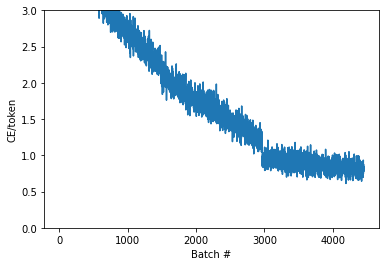

In [50]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')
plt.show()

## Translate

Now that the model is trained let's implement a function to execute the full `text => text` translation.

For this the model needs to invert the `text => token IDs` mapping provided by the `output_text_processor`. It also needs to know the IDs for special tokens. This is all implemented in the constructor for the new class. The implementation of the actual translate method will follow.

Overall this is similar to the training loop, except that the input to the decoder at each time step is a sample from the decoder's last prediction.

### Implementing the translation loop.

Here is a complete implementation of the text to text translation loop.

This implementation collects the results into python lists, before using `tf.concat` to join them into tensors.

This implementation statically unrolls the graph out to `max_length` iterations.
This is okay with eager execution in python.

If you want to export this model you'll need to wrap this method in a `tf.function`. This basic implementation has a few issues if you try to do that:

1. The resulting graphs are very large and take a few seconds to build, save or load.
2. You can't break from a statically unrolled loop, so it will always run `max_length` iterations, even if all the outputs are done. But even then it's marginally faster than eager execution.




In [51]:
class Translator(tf.Module):
  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.experimental.preprocessing.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '<sos>']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string('<sos>')
    self.end_token = index_from_string('<eos>')

  def tokens_to_text(self, result_tokens):
    result_text_tokens = self.output_token_string_from_index(result_tokens)
    result_text = tf.strings.reduce_join(result_text_tokens,
                                        axis=1, separator=' ')
    result_text = tf.strings.strip(result_text)
    return result_text

  def sample(self, logits, temperature):
    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
    # Set the logits for all masked tokens to -inf, so they are never chosen.
    logits = tf.where(self.token_mask, -np.inf, logits)
    if temperature == 0.0:
      new_tokens = tf.argmax(logits, axis=-1)
    else: 
      logits = tf.squeeze(logits, axis=1)
      new_tokens = tf.random.categorical(logits/temperature,
                                          num_samples=1)
    return new_tokens

  def translate(self,
                  input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
    batch_size = tf.shape(input_text)[0]
    input_tokens = self.input_text_processor(input_text)
    enc_output, enc_state = self.encoder(input_tokens)

    dec_state = enc_state
    new_tokens = tf.fill([batch_size, 1], self.start_token)

    result_tokens = []
    attention = []
    done = tf.zeros([batch_size, 1], dtype=tf.bool)

    for _ in range(max_length):
      dec_input = DecoderInput(new_tokens=new_tokens,
                              enc_output=enc_output,
                              mask=(input_tokens!=0))
      
      dec_result, dec_state = self.decoder(dec_input, state=dec_state)

      attention.append(dec_result.attention_weights)

      new_tokens = self.sample(dec_result.logits, temperature)

      # If a sequence produces an `end_token`, set it `done`
      done = done | (new_tokens == self.end_token)
      # Once a sequence is done it only produces 0-padding.
      new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

      # Collect the generated tokens
      result_tokens.append(new_tokens)

      if tf.executing_eagerly() and tf.reduce_all(done):
        break

    # Convert the list of generates token ids to a list of strings.
    result_tokens = tf.concat(result_tokens, axis=-1)
    result_text = self.tokens_to_text(result_tokens)

    if return_attention:
      attention_stack = tf.concat(attention, axis=1)
      return {'text': result_text, 'attention': attention_stack}
    else:
      return {'text': result_text}

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def tf_translate(self, input_text):
    return self.translate(input_text)


### Translator instance.

In [52]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

### User input.

In [53]:
inp[500:505], targ[500:505], 

(['lâchez-vous !',
  'à terre !',
  'au sol !',
  'descends.',
  "va voir ailleurs si j'y suis\u202f!"],
 ['get down.', 'get down.', 'get down.', 'get down.', 'get lost!'])

In [55]:
while True:
  text = input("Enter a french sentence:\n")
  if text.lower() == "exit":
    break
  text_cleaned = tf_lower_and_split_punct(text).numpy().decode()
  input_text = tf.constant([text_cleaned])
  print()
  result = translator.translate(input_text)
  result = result['text'][0].numpy().decode()
  print(f"French: > {text}")
  print(f"English: < {result}")
  print()

Enter a french sentence:
lâchez-vous !

French: > lâchez-vous !
English: < beautiful speed .

Enter a french sentence:
Va

French: > Va
English: < lets do it right up .

Enter a french sentence:
va voir ailleurs si j'y suis\u202f!

French: > va voir ailleurs si j'y suis\u202f!
English: < go down to it until i come out .

Enter a french sentence:
exit
